# 9. Mély számítógépes látás
## Könyvtárak

In [1]:
import os
import torch
import random
import zipfile
import tarfile
import requests
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as F
import torchvision.models.detection as detection
from torchvision.datasets import VOCSegmentation
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Adathalmaz
PASCAL VOC adathalmaz. A letöltésben a validációs halmaz fog letöltődni a kisebb mérete miatt. Tanítás esetén érdemes a tanító, validáció és teszt adatokat külön letölteni. 

In [2]:
class Transform:
    def __call__(self, img, target):
        return transforms.ToTensor()(img), transforms.ToTensor()(target)

transform = Transform()

# Download and load the Pascal VOC dataset
dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transforms=transform)

# Véletlen részhalmaz kiválasztása az adathalmazból
random_indices = random.sample(range(len(dataset)), 200)
subset = torch.utils.data.Subset(dataset, random_indices)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


## Modell

In [3]:
# Load a pre-trained Mask R-CNN model
model = detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)

model.to(device)

# Put the model in evaluation mode
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Predikció az adathalmazon

In [53]:
predictions = []

for img, target in subset:
    with torch.no_grad():
        prediction = model([img.to(device)])
    predictions.append({'prediction': prediction, 'target': target, 'image': img})

## Kiértékelés
### Maszkok összefésülésére függvény

In [62]:
def merge_masks(masks, cap = True):
    result = np.zeros((masks.shape[2], masks.shape[3]))
    for i in range(masks.shape[0]):
        mask = masks[i, 0, :, :]
        binary_mask = mask > 0.5
        if cap:
            result[binary_mask] = 1
        else:
            result[binary_mask] = mask[binary_mask]
    return result

### IoU kiszámítása egy képpárra

In [63]:
def calculate_iou(prediction, target):
    prediction = np.array(prediction)
    target = np.array(target)
    
    target[target > 0] = 1 
    prediction = prediction.astype(int)
    target = target.astype(int)

    # Flatten the tensors to simplify calculation
    prediction_flat = prediction.reshape(-1)
    target_flat = target.reshape(-1)

    # Calculate intersection and union
    intersection = (prediction_flat * target_flat).sum()
    union = prediction_flat.sum() + target_flat.sum() - intersection

    # Compute the IoU
    iou = (intersection + 1e-6) / (union + 1e-6)  # Adding a small value to avoid division by zero
    return iou.item()

### IoU kiszámítása minden képre

In [61]:
ious = []

for entry in predictions:
    target_masks = entry['target'][0]
    pred_masks = entry['prediction'][0]['masks']
    pred_masks_merged = merge_masks(pred_masks)

    iou = calculate_iou(pred_masks_merged, target_masks)
    ious.append(iou)

# Calculate the average IoU across all images
average_iou = sum(ious) / len(ious)
print(f"Átlagos IoU: {round(average_iou * 100, 2)}%")

Átlagos IoU: 68.74%


## Eredmények ábrázolása
### Szegmentációs maszkok

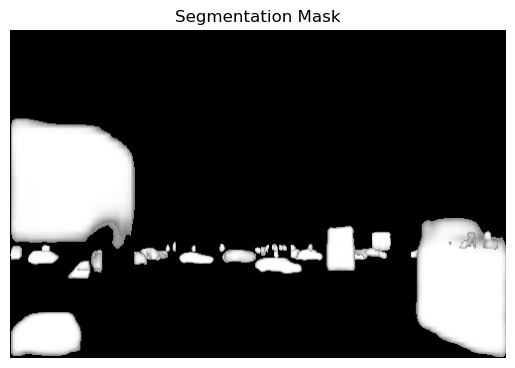

In [64]:
# Extract the first mask
test_mask = merge_masks(predictions[0]['prediction'][0]['masks'], cap=False)

plt.imshow(test_mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')  # Turn off axis numbers and labels
plt.show()

### Eredeti kép, valós maszk és becsült maszk

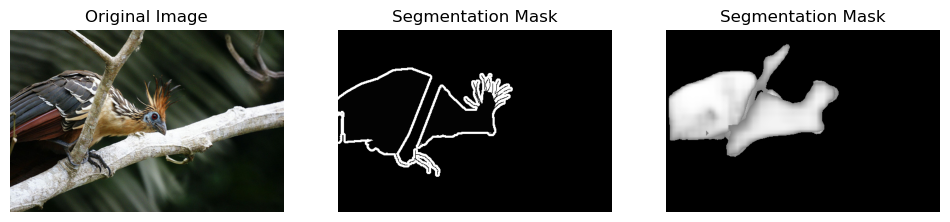

In [66]:
idx = 2  # Itt lehet kép ID-t választani 
threshold = 0.5

# Extract the first image and mask from the predictions
image = predictions[idx]['image']
mask = merge_masks(predictions[idx]['prediction'][0]['masks'], cap=False)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))  # Create a figure with two subplots

# Display the original image
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis('off')  # Turn off axis numbers and labels

ax[1].imshow(predictions[idx]['target'][0, :, :].numpy(), cmap='gray')
ax[1].set_title("Segmentation Mask")
ax[1].axis('off')  # Turn off axis numbers and labels

# Display the binary mask
ax[2].imshow(mask, cmap='gray')
ax[2].set_title("Segmentation Mask")
ax[2].axis('off')  # Turn off axis numbers and labels

plt.show()

---
# OneFormer
Telepítési útmutató: https://github.com/SHI-Labs/OneFormer/blob/main/INSTALL.md

In [2]:
# Setup detectron2 logger
import os
import sys
import warnings

sys.path.append('OneFormer/demo/')

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

# Import OneFormer Project
from OneFormer.demo.defaults import DefaultPredictor
from OneFormer.oneformer.config import add_swin_config
from OneFormer.oneformer.config import add_dinat_config
from OneFormer.oneformer.config import add_common_config
from OneFormer.oneformer.config import add_convnext_config
from OneFormer.oneformer.config import add_oneformer_config
from OneFormer.demo.visualizer import Visualizer, ColorMode

# Configs
setup_logger()
setup_logger(name="oneformer")
warnings.filterwarnings('ignore')